## Travail Personnel 2 : " Traffic flow ".

---


L'objectif de ce nouveau travail personnel est de réussir à modéliser et à décrire le système qu'est le flux de la circulation sur une route à une seule voie.

Pour se faire, nous nous plaçerons ici dans le cas d'un trafic instable pour lequel nous pouvons utiliser l'équation de convection non-linéaire de la densité de voiture. En outre, nous procèderons à 2 simulations distingues afin de mieux comprendre l'évolution de notre système sous différente conditions initiales (CI) et aux bords/limites (CL) pour la densité de trafic. Nous aurons ainsi les 2 ensemble de conditions suivant :

Première simulation :

$$
\left.
    \begin{array}{ll}
         & x = numpy.linspace(0,L,nx)\\
         & rho0  = numpy.ones(nx).10\\
         & rho0[10:20]  = 50\\
    \end{array}
\right \} \text{  (CI) }
$$


$$
\left.
    \begin{array}{ll}
         & \rho(0,t) = 10
    \end{array}
\right \} \text{  (CL)}
$$

Seconde simulation :

$$
\left.
    \begin{array}{ll}
         & x = numpy.linspace(0,L,nx)\\
         & rho0  = numpy.ones(nx).20\\
         & rho0[10:20]  = 50\\
    \end{array}
\right \} \text{  (CI) }
$$


$$
\left.
    \begin{array}{ll}
         & \rho(0,t) = 20
    \end{array}
\right \} \text{  (CL)}
$$

Commençons sans plus tarder par le traitement de nos équations.

##### 1. Réécriture de l'équation de convection non-linéaire de la densité de voiture.
---

Dans la partie théorique de l'énoncé de ce travail, nous avons vu que le flux, instable, de trafic peut-être modélisé comme la convection non-linéaire de la densité de voiture. Il en découllait donc pour notre problème:

\begin{align}
\frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial \rho} \frac{\partial \rho}{\partial x} = 0\\
\end{align}


où

\begin{align}
F = V(\rho) \rho = V_{max} \rho (1- \frac{\rho}{\rho_{max}})
\end{align}

Avec,

$$
\left\{
    \begin{array}{ll}
        &.V  \text{, la vitesse de circulation (en km/h)} \\
        &.V_{max}  \text{, vitesse maximale que peuvent atteindre les}\\
        &\hspace{0.9cm}  \text{voiture lorsque $\rho→0$}\\
        &.\rho \text{, la densité de trafic, c'est à dire le nombre de voiture}\\
        &\hspace{0.9cm}  \text{par unité de longueur de la route (en voiture/km)}\\
        &. \rho_{max},  \text{la densité maximale atteinte lorsque les voiture}\\
        &\hspace{0.9cm}  \text{sont "pare-chocs contre pare-chocs", et à laquelle}\\
        &\hspace{0.9cm}  \text{correspond une vitesse nulle}
    \end{array}
\right.
$$

En appliquant la $règle\ de\ la\ chaîne^{1}$ sur l'équation (1), nous obtenons alors: 

\begin{align}
\frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial x} = 0\\
\end{align}


---
###### [1]. La règle de dérivation des fonctions composées ou "règle de la chaîne" s'énonce comme suit : Soit f une fonction dérivable en a et g dérivable en f(a). Alors la composition g o f est dérivable en a et on a : $(g◦f)'(a) = g'(f(a)) f'(a)$ ou dans la notation de Leibniz si $y=f(x)$ et $u=g(y)$ alors : $\frac{du}{dx}=\frac{du}{dy} \frac{dy}{dx}$


Passons à présent à la discrétisation de l'équation (1). Calculons tout dabord la dérivée $\frac{\partial F}{\partial \rho}$. Pour se faire nous allons utiliser l'une des fonctionnalités proposées par $sympy^{2}$ à savoir le calcul d'une dérivée partielle. 

Commençons donc par importer la librairie sympy.

---
###### [2] . Sympy est une librairie pour python qui propose de nombreuse fonctionnalités similaires à celle proposée par Mathematica tel que le calcul de dérivée, d'integrale, etc.

In [15]:
# Import de la libraire.
import sympy

# Permet le renvois des résultats dans le style "LaTeX".
from sympy import init_printing
init_printing()

Définissons à présent nos variables, l'expression de F (donnée par l'équation (2) ) et calculons enfin sa dérivée par rapport à $\rho$.

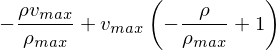

In [16]:
# On définit nos variables.
v_max, rho, rho_max = sympy.symbols('v_max rho rho_max')

# Expression de F.
F = v_max*rho*(-(rho/rho_max)+1)

# Calcul de la dérivée.
Fprime = F.diff(rho)

# Affichage du résultat.
Fprime

Nous pouvons réexprimer ceci en mettant $v_{max}$ en évidence et en simplifiant quelque peu les sommes:


$\hspace{2.5cm}\frac{- \rho v_{max}}{\rho_{max}}+ v_{max}(- \frac{\rho}{\rho_{max}}+1)$ → $v_{max}(1- \frac{2 \rho}{\rho_{max}})$

Ainsi, nous avons obtenu grâce à sympy :

\begin{equation}
\frac{\partial F}{\partial \rho} = v_{max}(1- \frac{2 \rho}{\rho_{max}}) 
\end{equation}

Et l'équation (1) devient alors :

\begin{equation}
\frac{\partial \rho}{\partial t} + v_{max}(1- \frac{2 \rho}{\rho_{max}})  \frac{\partial \rho}{\partial x} = 0\\
\end{equation}

Nous pouvons à présent passer à la discrétisation de notre equation de convection et ceci afin de pouvoir résoudre numériquement notre problème. Pour se faire, nous utilisons comme demandé dans l'énoncé de ce travail personnel, la "forward-difference" pour la dérivée par rapport au temps et la "backward-difference" pour la dérivée par rapport à l'espace (ici, par rapport à x comme nous travaillons avec une équation à 1 dimension).

Pour rappel, les discrétisations "forward-difference" et "backward-difference" de la dérivée partielle $\partial u/ \partial x$ (par exemple) sont données par :

* Forward-difference: si on utilise les points $x_i$ et $x_i + \Delta x$ alors la dérivée devient : $\frac{\partial u}{\partial x} \approx \frac{u(x_{i+1})-u(x_i)}{\Delta x}$.
* Backward-difference: si on utilise les points $x_i$ et $x_i- \Delta x$ alors la dérivée devient : $\frac{\partial u}{\partial x} \approx \frac{u(x_i)-u(x_{i-1})}{\Delta x}$.

Donc en appliquant ces deux discrétisations à l'équation (5) il en découle l'équation suivante:

\begin{equation}\frac{\rho_i^{n+1}-\rho_i^n}{\Delta t} + v_{max}(1- \frac{2 \rho_i^{n}}{\rho_{max}}) \frac{\rho_i^n - \rho_{i-1}^n}{\Delta x} = 0, \end{equation}

Où la seule inconnue est $\rho_i^{n+1}$ étant donné nos conditions initiales. En isolant cette inconnue nous obtenons :

\begin{equation}
\rho_i^{n+1}= \rho_i^{n}-\frac{\Delta t}{\Delta x} v_{max}(1- \frac{2 \rho_i^{n}}{\rho_{max}}) (\rho_i^n - \rho_{i-1}^n)
\end{equation}

Que nous pouvons maintenant traiter numériquement.

---

##### 2.  PARTIE A
---

In [3]:
print(Fprime)

-rho*v_max/rho_max + v_max*(-rho/rho_max + 1)


In [4]:
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

Après conversion des données dans les unités du Système International:

In [5]:
# Déclaration des variables

v_max = 80  # en m/s
L     = 11       # en m
rho_max = 250     # en voitures/m
nx    = 51
nt    = 101
dt    = .001     # en s
dx= 2/(nx-1)

print(dx)

0.04


affichage de la vague

In [6]:
# Conditions initiales pour la densité de trafic:

x = numpy.linspace(0,L,nx)
rho0 = numpy.ones(nx)*10
rho0[10:20] = 50
print(rho0)

[ 10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  50.  50.  50.  50.  50.
  50.  50.  50.  50.  50.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.  10.  10.  10.  10.]


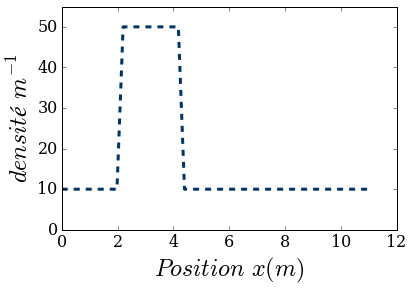

In [7]:
pyplot.ylabel('$densité$'' ''$m^{-1}$', fontsize=24) # nom de l'axe x & taille de la police
pyplot.xlabel('$Position$'' ''$x(km)$', fontsize=24) # nom de l'axe y & taille de la police
pyplot.plot(x, rho0, color='#003366', ls='--', lw=3)
pyplot.ylim(0,55);

In [8]:
def v(rho):

    return v_max*(1-(rho0/rho_max))

In [9]:
print (v(rho0))

[ 76.8  76.8  76.8  76.8  76.8  76.8  76.8  76.8  76.8  76.8  64.   64.
  64.   64.   64.   64.   64.   64.   64.   64.   76.8  76.8  76.8  76.8
  76.8  76.8  76.8  76.8  76.8  76.8  76.8  76.8  76.8  76.8  76.8  76.8
  76.8  76.8  76.8  76.8  76.8  76.8  76.8  76.8  76.8  76.8  76.8  76.8
  76.8  76.8  76.8]


In [10]:
s= 64*10/36
print(s)


17.77777777777778


In [11]:
#for n in range(1,nt):           # boucle temporelle 
#    rho_n = rho0.copy()  
   
#    for i in range(1,nx):       # boucle spatiale 
#        rho0[i] = rho_n[i]-dt/dx*v_max*(1-((2/rho_max)*rho_n[i]))*(rho_n[i]-rho_n[i-1])

In [12]:
for n in range(1, nt):  
    rhon = rho0.copy() 
    rho0[1:] = rhon[1:]-((dt/dx)*v_max*(1-((2/rho_max)*rhon[1:]))*(rhon[1:]-rhon[0:-1]))
    rho0[0]=10    # Notre condition au bord

/serveur/logiciels/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in multiply
  app.launch_new_instance()
/serveur/logiciels/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in subtract
  app.launch_new_instance()


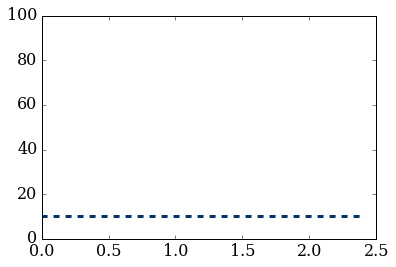

In [13]:
pyplot.plot(x, rho0, color='#003366', ls='--', lw=3)
pyplot.ylim(0,100);

##### Source:


[1] Cours de MATH-F-101 (Calcul Différentiel et Intégral 1) présenté par M. Joel Fine et M. Denis Bonheure à l'ULB.

---

###### The cell below loads the style of the notebook.

In [14]:
from IPython.core.display import HTML
css_file = '../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())